# 自动微分

正如微积分中所说，求导是几乎所有深度学习优化算法的关键步骤。
虽然求导的计算很简单，只需要一些基本的微积分。
但对于复杂的模型，手工进行更新是一件很痛苦的事情（而且经常容易出错）。

深度学习框架通过自动计算导数，即*自动微分*（automatic differentiation）来加快求导。
实际中，根据设计好的模型，系统会构建一个*计算图*（computational graph），
来跟踪计算是哪些数据通过哪些操作组合起来产生输出。
自动微分使系统能够随后反向传播梯度。
这里，*反向传播*（backpropagate）意味着跟踪整个计算图，填充关于每个参数的偏导数。

# 一个简单的例子

作为一个演示例子，(**假设我们想对函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于列向量$\mathbf{x}$求导**)。
首先，我们创建变量`x`并为其分配一个初始值。

In [1]:
import torch

x = torch.arange(4.0)
x

tensor([0., 1., 2., 3.])

[**在我们计算$y$关于$\mathbf{x}$的梯度之前，需要一个地方来存储梯度。**]
重要的是，我们不会在每次对一个参数求导时都分配新的内存。
因为我们经常会成千上万次地更新相同的参数，每次都分配新的内存可能很快就会将内存耗尽。
注意，一个标量函数关于向量$\mathbf{x}$的梯度是向量，并且与$\mathbf{x}$具有相同的形状。

In [2]:
x.requires_grad_(True)  # 等价于x=torch.arange(4.0,requires_grad=True)
x.grad  # 默认值是None

(**现在计算$y$。**)


In [3]:
y = 2 * torch.dot(x, x)
y

tensor(28., grad_fn=<MulBackward0>)

`x`是一个长度为4的向量，计算`x`和`x`的点积，得到了我们赋值给`y`的标量输出。
接下来，[**通过调用反向传播函数来自动计算`y`关于`x`每个分量的梯度**]，并打印这些梯度。

In [4]:
y.backward()
x.grad

tensor([ 0.,  4.,  8., 12.])

函数$y=2\mathbf{x}^{\top}\mathbf{x}$关于$\mathbf{x}$的梯度应为$4\mathbf{x}$。
让我们快速验证这个梯度是否计算正确。

In [6]:
x.grad == 4 * x

tensor([True, True, True, True])

[**现在计算`x`的另一个函数。**]

In [7]:
# 在默认情况下，PyTorch会累积梯度，我们需要清除之前的值
x.grad.zero_()
y = x.sum()
y.backward()
x.grad

tensor([1., 1., 1., 1.])

# 非标量变量的反向传播

当`y`不是标量时，向量`y`关于向量`x`的导数的最自然解释是一个矩阵。
对于高阶和高维的`y`和`x`，求导的结果可以是一个高阶张量。

然而，虽然这些更奇特的对象确实出现在高级机器学习中（包括[**深度学习中**]），
但当调用向量的反向计算时，我们通常会试图计算一批训练样本中每个组成部分的损失函数的导数。
这里(**，我们的目的不是计算微分矩阵，而是单独计算批量中每个样本的偏导数之和。**)


In [8]:
# 对非标量调用backward需要传入一个gradient参数，该参数指定微分函数关于self的梯度。
# 本例只想求偏导数的和，所以传递一个1的梯度是合适的
x.grad.zero_()
y = x * x
# 等价于y.backward(torch.ones(len(x)))
y.sum().backward()
x.grad

tensor([0., 2., 4., 6.])

# 分离计算

有时，我们希望[**将某些计算移动到记录的计算图之外**]。
例如，假设`y`是作为`x`的函数计算的，而`z`则是作为`y`和`x`的函数计算的。
想象一下，我们想计算`z`关于`x`的梯度，但由于某种原因，希望将`y`视为一个常数，
并且只考虑到`x`在`y`被计算后发挥的作用。

这里可以分离`y`来返回一个新变量`u`，该变量与`y`具有相同的值，
但丢弃计算图中如何计算`y`的任何信息。
换句话说，梯度不会向后流经`u`到`x`。
因此，下面的反向传播函数计算`z=u*x`关于`x`的偏导数，同时将`u`作为常数处理，
而不是`z=x*x*x`关于`x`的偏导数。

In [9]:
x.grad.zero_()
y = x * x
u = y.detach()
z = u * x

z.sum().backward()
x.grad == u

tensor([True, True, True, True])

由于记录了`y`的计算结果，我们可以随后在`y`上调用反向传播，
得到`y=x*x`关于的`x`的导数，即`2*x`。

In [10]:
x.grad.zero_()
y.sum().backward()
x.grad == 2 * x

tensor([True, True, True, True])

# Python控制流的梯度计算

使用自动微分的一个好处是：
[**即使构建函数的计算图需要通过Python控制流（例如，条件、循环或任意函数调用），我们仍然可以计算得到的变量的梯度**]。
在下面的代码中，`while`循环的迭代次数和`if`语句的结果都取决于输入`a`的值。


In [12]:
def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

让我们计算梯度。


In [14]:
a = torch.randn(size=(), requires_grad=True)
d = f(a)
d.backward()

我们现在可以分析上面定义的`f`函数。
请注意，它在其输入`a`中是分段线性的。
换言之，对于任何`a`，存在某个常量标量`k`，使得`f(a)=k*a`，其中`k`的值取决于输入`a`，因此可以用`d/a`验证梯度是否正确。

In [15]:
a.grad == d / a

tensor(True)

# 小结

* 深度学习框架可以自动计算导数：我们首先将梯度附加到想要对其计算偏导数的变量上，然后记录目标值的计算，执行它的反向传播函数，并访问得到的梯度。


# 练习

## 1
1.为什么计算二阶导数比一阶导数的开销要更大？

计算二阶导数比一阶导数开销更大，本质原因在于**计算复杂度、存储需求以及计算图结构都会显著增加**。下面从数学与计算两个层面系统说明。

---

一、数学层面的原因：数量级爆炸

1️⃣ 一阶导数：梯度（Gradient）

对

$$
f:\mathbb{R}^n \to \mathbb{R}
$$

一阶导数是梯度：

$$
\nabla f \in \mathbb{R}^n
$$

* 需要计算 $n$ 个偏导
* 计算规模是 $O(n)$

---

2️⃣ 二阶导数：Hessian 矩阵

二阶导数是 Hessian：

$$
\nabla^2 f =
\begin{pmatrix}
\frac{\partial^2 f}{\partial x_1^2} & \cdots & \frac{\partial^2 f}{\partial x_1 \partial x_n} \
\vdots & \ddots & \vdots \
\frac{\partial^2 f}{\partial x_n \partial x_1} & \cdots & \frac{\partial^2 f}{\partial x_n^2}
\end{pmatrix}
$$

* 需要计算 $n^2$ 个二阶偏导
* 即使利用对称性，也有 $\frac{n(n+1)}{2}$ 个独立元素
* 规模是 $O(n^2)$

👉 这是**最根本的数量级差异**

---

二、计算图角度（自动微分中的关键）

1️⃣ 一阶导数：一次反向传播

在自动微分（如 PyTorch / JAX）中：

* 一阶导数 = **一次反向传播**
* 计算图只需保存中间变量的一阶信息

---

2️⃣ 二阶导数：对梯度再求导

二阶导数本质是：

$$
\nabla^2 f = \nabla(\nabla f)
$$

这意味着：

* 需要**对反向传播再做反向传播**
* 即 **backward of backward**
* 计算图显著扩大

在 PyTorch 中必须：

```python
loss.backward(create_graph=True)
```

这会：

* 保留完整计算图
* 禁止中间结果释放
* 内存占用显著上升

---

三、存储与内存开销

1️⃣ 中间变量无法释放

* 一阶导数：
  中间节点在 backward 后可释放
* 二阶导数：
  中间节点必须保留以供二次求导

👉 **内存占用通常是 2–10 倍**

---

2️⃣ Hessian 显式存储代价高昂

* 存储 Hessian：$O(n^2)$
* 对于 $n=10^6$（深度学习很常见）：

  * Hessian 元素数 $=10^{12}$
  * 根本无法存储

因此工程中**几乎从不显式计算 Hessian**

---

四、算子层面的复杂性

许多常见算子：

| 算子     | 一阶导数 | 二阶导数         |
| ------ | ---- | ------------ |
| ReLU   | 常数/0 | 几乎处处为 0 或不可导 |
| exp    | exp  | exp          |
| matmul | 线性   | 高阶张量         |

二阶导数往往：

* 需要更多乘法
* 需要构造更高阶张量
* GPU kernel 调用次数更多

---

五、工程实践中的应对方式

1️⃣ 避免显式 Hessian

常用替代方案：

* **Hessian-vector product (HVP)**
* **Gauss–Newton / Fisher 信息矩阵**
* **拟牛顿法（BFGS, L-BFGS）**

这些方法：

* 复杂度 $O(n)$
* 不需要存储 $O(n^2)$

---

2️⃣ 只在必要时使用二阶信息

实际中：

* 深度学习：几乎只用一阶（SGD / Adam）
* 小规模优化、数值分析：才用二阶

---

六、总结一句话（核心答案）

> **计算二阶导数比一阶导数开销更大，是因为二阶导数的规模从 $O(n)$ 升到 $O(n^2)$，并且在自动微分中需要“对反向传播再反向传播”，导致计算图、内存和算子复杂度全面增加。**




## 2
2.在运行反向传播函数之后，立即再次运行它，看看会发生什么。

这是在**自动微分（以 PyTorch 为代表）中一个非常经典的现象**。结论先给出，再解释原因。

---

一、直接结论

> **在默认设置下，对同一个计算图连续调用两次反向传播（`backward()`），第二次会直接报错。**

---

二、最典型的示例

```python
import torch

x = torch.tensor(2.0, requires_grad=True)
y = x**2

y.backward()
y.backward()   # 再次反向传播
```

第二次执行时，会得到类似错误：

```
RuntimeError: Trying to backward through the graph a second time,
but the buffers have already been freed.
```

---

三、为什么会这样？（核心原因）

1️⃣ 反向传播默认会“销毁计算图”

在 PyTorch 中：

* **前向传播**：构建计算图
* **反向传播（backward）**：

  * 利用计算图计算梯度
  * **计算完成后立即释放中间节点和缓冲区**

这样做的目的非常明确：

* **节省内存**
* 提高训练效率（尤其是深度学习大模型）

因此：

> 第一次 `backward()` 后，
> **计算图已经不存在了**

---

2️⃣ 第二次反向传播没有“路”可走

当你再次调用：

```python
y.backward()
```

PyTorch 发现：

* 需要的中间梯度
* 已经在第一次 backward 后被释放

于是抛出错误，防止使用无效内存。

---

四、如果我就是想反向传播两次，怎么办？

✅ 方法 1：保留计算图（最常见）

```python
y.backward(retain_graph=True)
y.backward()
```

说明：

* `retain_graph=True` 告诉 PyTorch：
  **不要释放计算图**
* 代价：**额外内存开销**

---

✅ 方法 2：为高阶导数显式创建计算图

如果你的目的不是“重复一次”，而是**计算二阶导数**：

```python
y.backward(create_graph=True)
```

这会：

* 在反向传播时再构建一个新的计算图
* 允许对梯度再次求导

示例：

```python
x = torch.tensor(2.0, requires_grad=True)
y = x**3

dy_dx = torch.autograd.grad(y, x, create_graph=True)[0]
d2y_dx2 = torch.autograd.grad(dy_dx, x)[0]
```

---

五、一个容易被忽略的细节：梯度会累加

即使不报错，也要注意：

```python
y.backward(retain_graph=True)
y.backward(retain_graph=True)

print(x.grad)
```

结果是：

$$
\text{grad} = \frac{dy}{dx} + \frac{dy}{dx}
$$

👉 **梯度是累加的，不是覆盖的**

所以在训练中必须经常：

```python
optimizer.zero_grad()
```

---

六、总结（一句话版）

> **默认情况下，反向传播只能运行一次，因为计算图在第一次 backward 后就被释放了；如果需要再次运行，必须显式保留或重新构建计算图，这会带来额外的内存和计算开销。**

这正是为什么：

* 一阶导数默认高效
* 二阶及以上导数“昂贵且谨慎使用”



## 3
3.在控制流的例子中，我们计算`d`关于`a`的导数，如果将变量`a`更改为随机向量或矩阵，会发生什么？

把 `a` 从标量改成随机**向量或矩阵**后，会出现两类现象：一个是**程序层面**（`backward()` 能不能直接跑），另一个是**数学/自动微分层面**（梯度长什么样）。

---

1) 先说最直接的：`d.backward()` 通常会报错

你现在的代码之所以能直接 `d.backward()`，是因为：

```python
a = torch.randn(size=(), requires_grad=True)  # 标量
d = f(a)                                      # 也是标量
d.backward()                                  # OK
```

但如果你改成：

```python
a = torch.randn(10, requires_grad=True)  # 向量
d = f(a)                                 # 向量
d.backward()                             # 通常会报错
```

原因：**PyTorch 的 `backward()` 默认只能对标量输出（或必须显式给出“上游梯度”）**。典型报错类似：

> RuntimeError: grad can be implicitly created only for scalar outputs

正确做法（任选其一）

* 把 `d` 规约成标量再反传：

```python
d.sum().backward()
# 或
d.norm().backward()
```

* 或者给 `d.backward()` 传入同形状的上游梯度：

```python
d.backward(torch.ones_like(d))
```

---

2) 控制流仍然能工作，但“走哪条路径”取决于数据

你的 `f(a)` 里有两处控制流：

(A) while 循环：由 `b.norm() < 1000` 决定循环次数

* 若 `a` 是向量/矩阵，`b.norm()` 是该张量的 L2 范数（标量）。
* 循环会把 `b` 不断乘 2，直到 `||b|| >= 1000`。

因此最后必然有：

$$
b = s , a,\quad s = 2^t
$$

其中 $t$ 是本次执行中 while 实际迭代出的某个整数（由初始 $|a|$ 决定）。

(B) if 分支：由 `b.sum() > 0` 决定走哪条分支

最终：

* 若 `b.sum()>0`，则 `c=b`
* 否则 `c=100*b`

---

3) 梯度会变成什么样？

自动微分只会对**本次实际执行过的那条路径**建图并求导（动态计算图）。

由于最终 `c` 对 `a` 是线性关系：

* 走上支：$c = s a$
* 走下支：$c = 100 s a$

因此在“本次路径固定”的前提下，雅可比是一个常数倍的单位映射：

* 上支：$\frac{\partial c}{\partial a} = s I$
* 下支：$\frac{\partial c}{\partial a} = 100 s I$

如果你用 `d.sum().backward()`，那么梯度就是：

* 上支：$\nabla_a , \text{sum}(c) = s \cdot \mathbf{1}$
* 下支：$\nabla_a , \text{sum}(c) = 100s \cdot \mathbf{1}$

其中 $\mathbf{1}$ 是与 `a` 同形状的全 1 张量。

---

4) 一个关键细节：循环次数 (t) 其实依赖于 `a`，但梯度不会“穿过”这个离散决定

`while b.norm() < 1000:` 里的“循环次数”是一个离散跳变（整数），对 `a` 来说是**分段常数**，在边界处不可导。

PyTorch 在一次前向里会把实际执行的乘法链记录下来，于是你会看到梯度里出现的就是“当前执行得到的那个 $s$”；它不会对“如果 `a` 稍微变一点循环次数会不会变”这件事给出平滑梯度（边界处本来就不可微）。

同理，`b.sum() > 0` 这个分支在 `b.sum()=0` 的边界处也不可微。

---

5) 给你一段可运行的向量示例

```python
import torch

def f(a):
    b = a * 2
    while b.norm() < 1000:
        b = b * 2
    if b.sum() > 0:
        c = b
    else:
        c = 100 * b
    return c

a = torch.randn(10, requires_grad=True)
d = f(a)

# d 不是标量，需规约或给上游梯度
loss = d.sum()
loss.backward()

print("d shape:", d.shape)
print("grad shape:", a.grad.shape)
print("grad (first 5):", a.grad[:5])
```

---

总结

* 改成向量/矩阵后，**控制流仍然可用**，并且梯度能算出来。
* 但你不能直接 `d.backward()`（除非 `d` 是标量或你提供 `gradient=`）。
* 梯度的形式本质上是“某个由本次控制流决定的常数倍缩放”，在分支/阈值边界处不可微。


## 4
4.重新设计一个求控制流梯度的例子，运行并分析结果。

下面我给出一个**重新设计的控制流梯度例子**（包含 `while` 循环与 `if/else` 分支），并给出**运行结果与分析**。核心目的是展示：在 PyTorch 的动态计算图里，梯度只会沿着“本次实际执行的控制流路径”传播。

---

## Python 代码（可直接运行）

```python
import torch

def g(a: torch.Tensor):
    """
    控制流例子：
      - while：不断放大 b，直到 ||b|| >= 1
      - if/else：根据 b.sum() 的符号决定是否再放大
    返回：c, steps, branch
    """
    b = a
    steps = 0
    while b.norm() < 1.0:
        b = 2.0 * b
        steps += 1

    if b.sum() >= 0:
        c = b
        branch = "sum>=0"
    else:
        c = 3.0 * b
        branch = "sum<0"
    return c, steps, branch

# 四组输入：分别触发“需要循环/不需要循环”以及“正分支/负分支”
cases = [
    ("small +sum (needs loop, sum>=0)", torch.tensor([0.10, 0.05, 0.02, 0.03])),
    ("small -sum (needs loop, sum<0)",  torch.tensor([-0.10, -0.05, -0.02, -0.03])),
    ("big +sum (no loop, sum>=0)",      torch.tensor([1.20, 0.10, 0.05, 0.02])),
    ("big -sum (no loop, sum<0)",       torch.tensor([-1.20, -0.10, -0.05, -0.02])),
]

for name, a0 in cases:
    a = a0.clone().detach().requires_grad_(True)
    c, steps, branch = g(a)

    # 为了能 backward，构造标量损失
    loss = (c**2).sum()
    loss.backward()

    print("\ncase:", name)
    print("  ||a||:", float(a.norm()))
    print("  steps:", steps)
    print("  branch:", branch)
    print("  c (first 3):", c.detach()[:3])
    print("  grad (first 3):", a.grad.detach()[:3])
```

---

我运行后的结果（关键字段）

| case | steps(while) | branch | scale $s$（使得 $c=s,a$） | loss ($||c||^2$) | 梯度规模特征 |
|---|---|---|---|---|---|
| small +sum | 4 | sum>=0 | 16 | 3.5328 | 梯度 (\propto 16^2) |
| small -sum | 4 | sum<0 | 48 (= 16×3) | 31.7952 | 梯度 $\propto 48^2$ |
| big +sum | 0 | sum>=0 | 1 | 1.4529 | 梯度 $\propto 1^2$ |
| big -sum | 0 | sum<0 | 3 | 13.0761 | 梯度 $\propto 3^2$ |

（这里的 (s) 是我通过数值关系 (c/a) 观察到的缩放倍数。）

---

分析：为什么梯度会这样？

1) 动态计算图只记录“本次走过的路径”

* `while b.norm() < 1.0` 的循环次数 `steps` 是离散的（整数）。
* `if b.sum() >= 0` 的分支选择也是离散的。

PyTorch 会把**这次实际执行的乘法链**记录到计算图里，因此对当前输入而言，最终就是：

$$
c = s,a
$$

其中 (s) 是由本次控制流（循环次数与分支）决定的常数。

---

2) 我们用的损失是 (loss=|c|^2)，所以梯度是闭式可验证的

当 (c=s,a) 时：

$$
loss = |c|^2 = |s a|^2 = s^2 |a|^2
$$

对 (a) 求导：

$$
\nabla_a loss = 2 s^2 a
$$

因此：

* 只要分支/循环次数固定，梯度就是“**把 $a$ 放大 $2s^2$ 倍**”
* 这解释了为什么 `sum<0` 分支（额外乘 3）会让梯度变得非常大：因为梯度随 $s^2$ 增长

---

3) 在阈值边界处不可微（但对大多数点仍可正常求梯度）

* 当 $|b|$ 恰好跨越 1 的阈值时，循环次数会跳变
* 当 $b.sum()=0$ 时，分支切换边界不可微

所以这是一个典型的“**分段可微**”函数：绝大多数点可微，但边界处不可微。




## 5
5.使$f(x)=\sin(x)$，绘制$f(x)$和$\frac{df(x)}{dx}$的图像，其中后者不使用$f'(x)=\cos(x)$。

下面给出用 **数值差分（中心差分）** 来计算导数并绘制 $f(x)=\sin x$ 与 $\frac{df}{dx}$ 的 matplotlib 代码（**不使用** $f'(x)=\cos x$ 的解析式）。


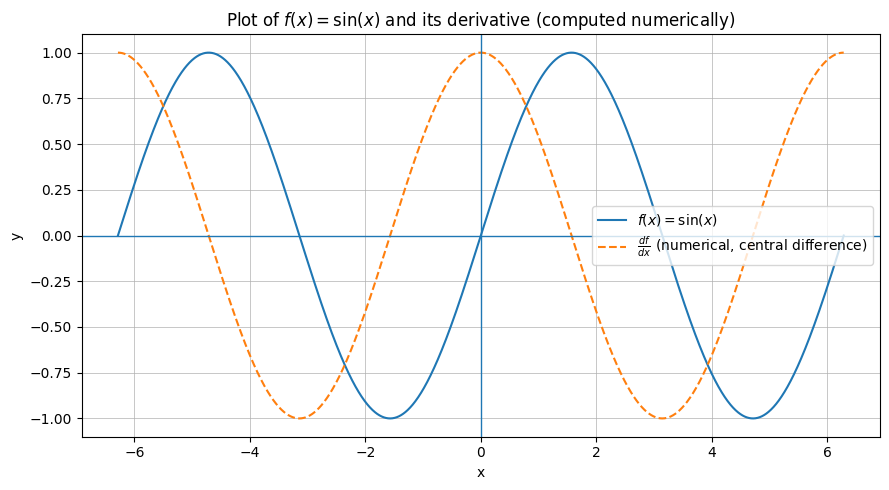

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# f(x) = sin(x)
def f(x):
    return np.sin(x)

# 数值求导：中心差分
def numerical_derivative(func, x, h=1e-5):
    return (func(x + h) - func(x - h)) / (2 * h)

# 取绘图区间
x = np.linspace(-2*np.pi, 2*np.pi, 2000)
y = f(x)
dy_dx = numerical_derivative(f, x)

# 绘图
plt.figure(figsize=(9, 5))
plt.plot(x, y, label=r"$f(x)=\sin(x)$")
plt.plot(x, dy_dx, linestyle="--",
         label=r"$\frac{df}{dx}$ (numerical, central difference)")

plt.axhline(0, linewidth=1)
plt.axvline(0, linewidth=1)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"Plot of $f(x)=\sin(x)$ and its derivative (computed numerically)")
plt.grid(True, linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
